# n-step Temporal Difference

MC is an infinite-step method: it goes all the way until the end of the episode; TD is a one-step method: it interacts with the environment for a single step. We can generalize into an n-step method.

$\displaystyle V(S_t) = V(S_t) + \alpha_t [G_{t:t+n} - V(S_t)] $

In [1]:
import numpy as np

def decay_alpha(init_value, min_value, decay_steps, max_steps):
    rem_steps = max_steps - decay_steps
    values = np.logspace(start=0, stop=-2, num=decay_steps, base=10)
    values = (values - values.min()) / (values.max() - values.min())
    values = (init_value - min_value) * values + min_value
    values = np.pad(values, (0, rem_steps), 'edge')
    return values

In [ ]:
def decay_discounts(gamma, max_steps):
    discounts = np.logspace(start=0, stop=max_steps, num=max_steps, base=gamma, endpoint=False);
    return discounts

We need a function to generate the sub-path of n steps:

In [3]:
def generate_path(pi, env, state, n_steps):
    path = []
    done = False
    while len(path) < n_steps:
        action = pi(state) 
        next_state, reward, done, _ = env.step(action)
        experience = (state, action, reward, next_state, done)
        path.append(experience)
        if done: 
            break
        state = next_state
    return np.array(path, object)

It is a hybrid between MC and TD: we need to generate some steps, but instead of going to the end of the episode (like in MC) implementation, we go to  n steps before bootstrapping the estimate: 

In [4]:
def ntd(pi, env, gamma=1.0, n_steps=3, init_alpha=0.5, min_alpha=0.01, decay_episodes=350, n_episodes=500):

    nS = env.observation_space
    
    # calculate n_step discounts at once 
    discounts = decay_discounts(gamma, n_steps+1);
    
    # calculate all alphas at once
    alphas = decay_alpha(init_alpha, min_alpha, decay_episodes, n_episodes);
      
    # initialize the current estimate of the state-value function
    # and a per-episode copy of V for offline analysis
    V = np.zeros(nS, dtype=float)
    V_track = np.zeros((n_episodes, nS), dtype=float)
    
    # loop for every episode 
    for e in range(n_episodes):

        # get the initial state
        state, done = env.reset(), False

        # go collecting a series of n-state paths until we hit done
        while not done:
            # generate a path of n-steps (maximum, or less if we hit done)
            path = generate_path(pi, env, state, n_steps)
            
            # calculate the number of steps, could be ‘n_step’ but it could 
            # also be smaller if a terminal state is in the path    
            n = len(path)
        
            # initialize a visits check vector
            visited = np.zeros(nS, dtype=bool)
        
            # now loop through all experiences in the path
            for t, (path_state, _, reward, path_next_state, path_done) in enumerate(path):                
                
                # calculate the partial return
                partial_return = np.sum(discounts[:n-t] * path[t:, 2])
            
                # update the value function
                ntd_target = partial_return + discounts[n] * V[path[n-1, 3]]
                ntd_error = ntd_target - V[path_state]
                V[path_state] = V[path_state] + alphas[e] * ntd_error
                                           
                state = path_next_state
                done = path_done
                
        # keep track of the episode’s V
        V_track[e] = V
                      
    return V.copy(), V_track

We ran the policy evaluation algorithms on the Random Walk (RW) environment.

In [5]:
import numpy as np
    
class RandomWalk:
    """
    State Index:   [ 0    1    2    3    4    5    6 ]
    State Label:   [ .    A    B    C    D    E    . ]
    Type:          [ T    .    .    S    .    .    T ]    
    """
    V_true =       [0.0, 1/6, 2/6, 3/6, 4/6, 5/6, 0.0]
    
    def __init__(self):
        self.reset()

    def reset(self):
        self.observation_space = 7
        self._state = np.random.choice([1,2,3,4,5])
        self._done = False
        return self._state

    def step(self, action):
        if self._done: 
            raise ValueError('Episode has terminated');
        
        if action not in [0, 1]: 
            raise ValueError('Invalid action');
        
        self._state += np.random.choice([-1, 1])
        
        reward = 0
        
        if self._state < 1: 
            self._done = True
        
        if self._state > 5: 
            self._done = True; 
            reward = 1
        
        return self._state, reward, self._done, 0  # obs, rew, done

In [6]:
random_walk = RandomWalk()

We evaluate an "all-left" policy

In [7]:
def pi(state):
    return 1

We use the n-step Temporal-Difference prediction algorithm and show the estimates over episodes

In [9]:
V_ntd, V_ntd_track = ntd(pi, random_walk, n_steps=3, n_episodes=500)

In [10]:
print(V_ntd)

[0.         0.19852494 0.40982829 0.55484747 0.70355163 0.82568354
 0.        ]


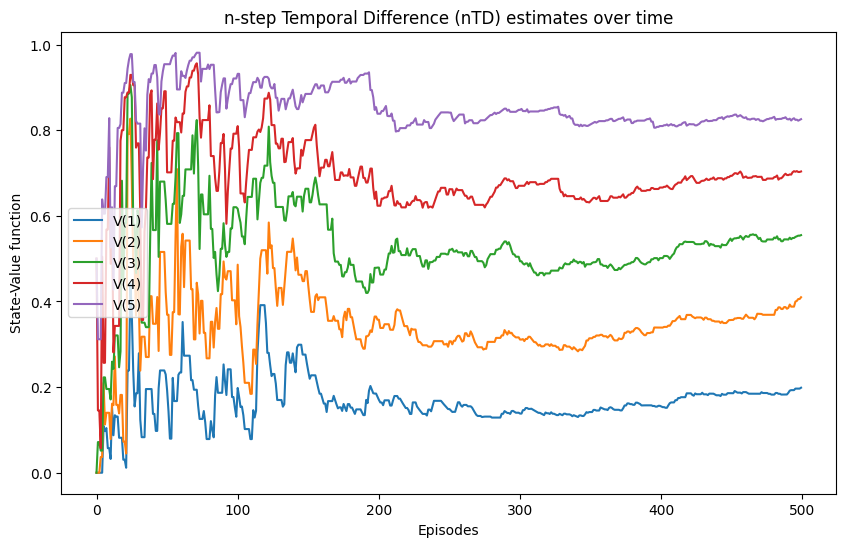

In [11]:
import matplotlib.pyplot as plt

legends = ['V(1)','V(2)','V(3)','V(4)','V(5)']
plt.figure(figsize=(10,6))
plt.plot(V_ntd_track[:,1:6])
plt.title('n-step Temporal Difference (nTD) estimates over time')
plt.ylabel('State-Value function')
plt.xlabel('Episodes')
plt.legend(legends)

plt.show()